## Models evaluation
### BagOfWords + SupportVectorMachine

In [16]:
import json
import os
import numpy as np
from data_processing import FullOneHot
import joblib
from tqdm.notebook import tqdm

weights_path = './run1-bow-word-svm/'
datapath = './data/hypatos-ds-test.json'
dictionary = json.load(open(os.path.join(weights_path,'dictionary.json'),'r'))
data = FullOneHot(datapath,chop_dataset_th=0.,dictionary=dictionary)
data.build_dataset()
kmeans_model = joblib.load(open(os.path.join(weights_path,'bow.pkl'),'rb'))
x = []
y = []
print('Transforming document feature vectors & preparing entities as targets')
for words_fv,entities in tqdm(zip(data.X,data.Y)):
    fvs = kmeans_model.transform(words_fv)
    entities_vector = np.zeros((len(fvs),)).astype(int)
    for entity in entities:
        entities_vector[entity] = 1
    x += [fvs]
    y += [entities_vector]
x = np.vstack(x)
y = np.hstack(y)


Processed documents:   0%|          | 0/886 [00:00<?, ?it/s]

Building feature vectors. n_jobs=6


Processed documents: 100%|██████████| 886/886 [00:58<00:00, 15.12it/s]


Transforming document feature vectors & preparing entities as targets


In [17]:
svm = joblib.load(open(os.path.join(weights_path,'svm.pkl'),'rb'))
svm.n_jobs = 6
predictions = svm.predict_proba(x)
svm_pr_curve = metrics.precision_recall_curve(y,predictions[:,1])#precision,recall,scores

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   6 | elapsed:  9.4min remaining: 18.8min
[Parallel(n_jobs=6)]: Done   6 out of   6 | elapsed: 14.9min finished


### Transformer text classifier

In [23]:

import torch
from data_processing import RawDataYielder
import json
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
from transformers import TransformerTextClassifier

model_path = './run13-selfattention-bbox-encoding/self-attention-epoch_1.pt'
datapath = './data/hypatos-ds-test.json'
print('Loading dictionary')
dictionary = json.load(open('./run10-selfattention-bbox-encoding/dictionary.json','r'))
print('Loading model at {}'.format(model_path))
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
selfattention = torch.load(model_path,map_location=device)
data = RawDataYielder(json_path=datapath,
                      dictionary=dictionary)
data_batcher = DataLoader(data,batch_size=1,num_workers=1,drop_last=True,shuffle=False) #Change data loader
selfattention.eval()
predictions = []
targets = []
with torch.no_grad():
    for idx, batch in tqdm(enumerate(data_batcher),total=len(data)):
        sequence = batch[0]
        target = batch[1]
        positions_x = batch[2].float()
        positions_y = batch[3].float()
        positions_page = batch[4].float()
        target = torch.autograd.Variable(target).long()
        if torch.cuda.is_available():
            sequence = sequence.cuda()
            target = target.cuda()
            positions_x = positions_x.cuda()
            positions_y = positions_y.cuda()
            positions_page = positions_page.cuda()
        prediction = selfattention(sequence,positions_x,positions_y,positions_page)
        predictions += [torch.sigmoid(prediction).cpu().numpy()]
        targets += [target.cpu().numpy()]
        

Loading dictionary
Loading model at ./run13-selfattention-bbox-encoding/self-attention-epoch_1.pt


### Precision & Recall curves

(0.0, 1.0)

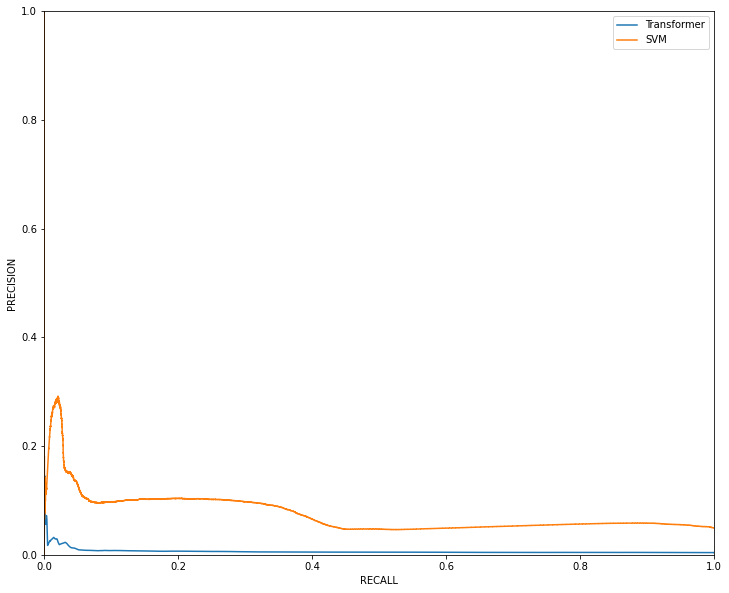

In [24]:
from sklearn import metrics
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np

all_predictions = np.hstack(predictions)
all_targets = np.hstack(targets)
# print(all_predictions.shape)
# print(all_targets.shape)
transformer_pr_curve = metrics.precision_recall_curve(all_targets[0],all_predictions[0])#precision,recall,scores

plt.figure(figsize=(12,10))
plt.plot(transformer_pr_curve[1],transformer_pr_curve[0],label='Transformer')
plt.plot(svm_pr_curve[1],svm_pr_curve[0],label='SVM')
plt.legend(loc=0)
plt.xlabel('RECALL')
plt.ylabel('PRECISION')
plt.xlim([0.,1.])
plt.ylim([0.,1.])